In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import string
import seaborn as sns
from textblob import TextBlob

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

### Same process after balancing the dataset

In [2]:
# Read the dataset
df = pd.read_csv("tweets_df_with_gender.csv")
df["Tweet"] = df["Text"]
df["Target"] = df["Gender"]
df = df[["Handle","Tweet", "Target"]]
df = df.replace(to_replace = "F", value = 1)
df = df.replace(to_replace = "M", value = 0)
print(len(df))

25165


In [3]:
df_M = df.loc[df['Target']==0]
df_M = df_M.sample(5000)
df_F = df.loc[df['Target']==1]
df_F = df_F.sample(5000)
df = pd.concat([df_M.reset_index(drop=True),df_F.reset_index(drop=True)], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

df.to_csv ('balanced_gender.csv', index = None, header=True)

In [23]:
X = df.iloc[:,1:].values
y = df.iloc[:,2:].values

In [24]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train.ravel()) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [29]:
y_pred = classifier.predict(X_test)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Confusion matrix:")
print(confusion_matrix(y_test,y_pred))
print(" ")
print(" ")
print("Classification report:") 
print(classification_report(y_test,y_pred))
print(" ")
print("Accuracy score:", accuracy_score(y_test, y_pred))

Confusion matrix:
[[767 255]
 [353 625]]
 
 
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.75      0.72      1022
           1       0.71      0.64      0.67       978

    accuracy                           0.70      2000
   macro avg       0.70      0.69      0.69      2000
weighted avg       0.70      0.70      0.69      2000

 
Accuracy score: 0.696


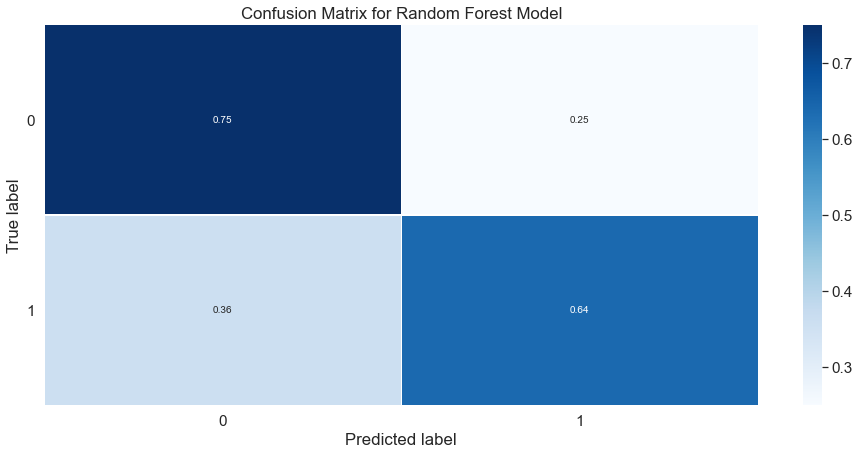

In [31]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['0', '1']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# 